In [1]:
#Imports
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm.notebook import tqdm
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from PIL import Image

In [16]:
#Set a path to save the final weights to
PATH = "/kaggle/working/model_state_dict.pt"

In [10]:
#Settings and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("using gpu")
else:
    print("using cpu")

bs_train, bs_val, bs_test = 16, 8, 1
epochs = 100
lr = 0.0001

In [3]:
#Create lists for the paths of training images and training masks 
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_29.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_28.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_19.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_24.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_31.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_30.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_32.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_34.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_1985

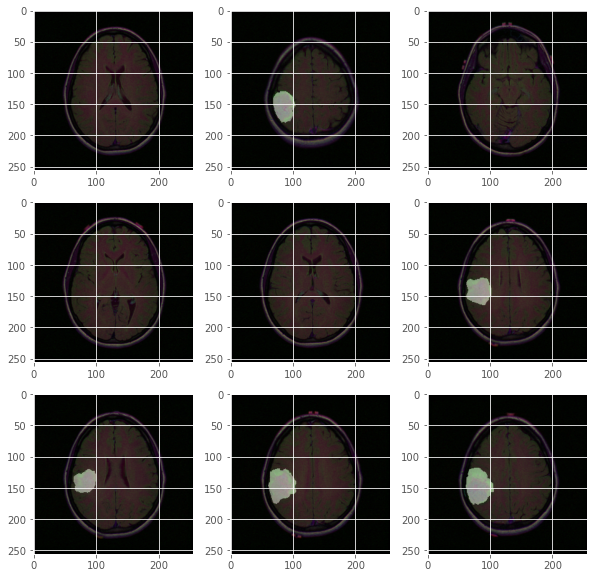

In [4]:
#Display some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [5]:
#Create dataframes with paths for training, validation, and testing
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)

In [6]:
#Create a custom dataset class which applies identical transformations to the training and validation data
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
        mask = resize(mask)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [7]:
#Datasets
train_dataset = MyDataset(df_train["filename"].values.tolist(), df_train["mask"].values.tolist())
val_dataset = MyDataset(df_val['filename'].values.tolist(), df_val['mask'].values.tolist())
test_dataset = MyDataset(df_test['filename'].values.tolist(), df_test["mask"].values.tolist())

In [11]:
#Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=bs_val, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs_test, shuffle=True)

In [12]:
#Define a dice loss function 
def dc_loss(pred, target):
    smooth = 100

    predf = pred.view(-1)
    targetf = target.view(-1)
    intersection = (predf * targetf).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (predf.sum() + targetf.sum() + smooth))

In [13]:
#Define the UNet architecture


def conv_layer(input_channels, output_channels):     #This is a helper function to create the convolutional blocks
    conv = nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True)
    )
    return conv

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_1 = conv_layer(3, 64)
        self.down_2 = conv_layer(64, 128)
        self.down_3 = conv_layer(128, 256)
        self.down_4 = conv_layer(256, 512)
        self.down_5 = conv_layer(512, 1024)
        
        self.up_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = conv_layer(1024, 512)
        self.up_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = conv_layer(512, 256)
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = conv_layer(256, 128)
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = conv_layer(128, 64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0)
        self.output_activation = nn.Sigmoid()
                
    def forward(self, img):     #The print statements can be used to visualize the input and output sizes for debugging
        x1 = self.down_1(img)
        #print(x1.size())
        x2 = self.max_pool(x1)
        #print(x2.size())
        x3 = self.down_2(x2)
        #print(x3.size())
        x4 = self.max_pool(x3)
        #print(x4.size())
        x5 = self.down_3(x4)
        #print(x5.size())
        x6 = self.max_pool(x5)
        #print(x6.size())
        x7 = self.down_4(x6)
        #print(x7.size())
        x8 = self.max_pool(x7)
        #print(x8.size())
        x9 = self.down_5(x8)
        #print(x9.size())
        
        x = self.up_1(x9)
        #print(x.size())
        x = self.up_conv_1(torch.cat([x, x7], 1))
        #print(x.size())
        x = self.up_2(x)
        #print(x.size())
        x = self.up_conv_2(torch.cat([x, x5], 1))
        #print(x.size())
        x = self.up_3(x)
        #print(x.size())
        x = self.up_conv_3(torch.cat([x, x3], 1))
        #print(x.size())
        x = self.up_4(x)
        #print(x.size())
        x = self.up_conv_4(torch.cat([x, x1], 1))
        #print(x.size())
        
        x = self.output(x)
        x = self.output_activation(x)
        #print(x.size())
        
        return x
        

In [15]:
#Initialize the model and optimizer
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))

In [17]:
#Load a preexisting set of weights if continuting training
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
#Training function 
def train(model, epochs):
    
    #Keep track of average training and validation losses for each epoch
    avg_train_losses = []
    avg_val_losses = []
    
    #Trigger for earlystopping
    earlystopping = False 

    #Training loop
    for epoch in range(epochs):
        
        #Record the training and validation losses for each batch in this epoch
        train_losses = []
        val_losses = []

        model.train()

        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (images, targets) in loop:

            images = images.to(device)
            targets = targets.to(device)

            model.zero_grad()
            pred = model(images)
            loss = dc_loss(pred, targets)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
                        
            with torch.no_grad():     #Show some samples at the first batch of each epoch 
                if batch == 1:
                    torch.save(model.state_dict(), PATH)

                    model.eval()

                    (img, mask) = next(iter(test_dataloader))
                    img = img.to(device)
                    mask = mask.to(device)
                    mask = mask[0]
                    pred = model(img)

                    plt.figure(figsize=(12,12))
                    plt.subplot(1,3,1)
                    plt.imshow(np.squeeze(img.cpu().numpy()).transpose(1,2,0))
                    plt.title('Original Image')
                    plt.subplot(1,3,2)
                    plt.imshow((mask.cpu().numpy()).transpose(1,2,0).squeeze(axis=2), alpha=0.5)
                    plt.title('Original Mask')
                    plt.subplot(1,3,3)
                    plt.imshow(np.squeeze(pred.cpu()) > .5)
                    plt.title('Prediction')
                    plt.show()

                    model.train()

                
        model.eval()
        
        with torch.no_grad():     #Record and print average validation loss for each epoch 
            for val_batch, (val_images, val_targets) in enumerate(val_dataloader):
                val_images = val_images.to(device)
                val_targets = val_targets.to(device)
                val_pred = model(val_images.detach())

                val_loss = dc_loss(val_pred, val_targets).item()

                val_losses.append(val_loss)

            epoch_avg_train_loss = np.average(train_losses)
            epoch_avg_val_loss = np.average(val_losses)
            avg_train_losses.append(epoch_avg_train_loss)
            avg_val_losses.append(epoch_avg_val_loss)

            print_msg = (f'train_loss: {epoch_avg_train_loss:.5f} ' + f'valid_loss: {epoch_avg_val_loss:.5f}')

            print(print_msg)
        
        if epoch > 5:     #Early stopping with a patience of 1 and a minimum of 5 epochs 
            if avg_val_losses[-1]>=avg_val_losses[-2]:
                print("Early Stopping Triggered With Patience 1")
                torch.save(model.state_dict(), PATH)
                earlystopping = True 
        if earlystopping:
            break

    return  model, avg_train_losses, avg_valid_losses

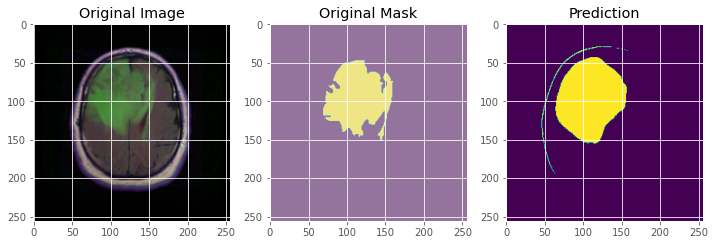

train_loss: 0.94065 valid_loss: 0.94408


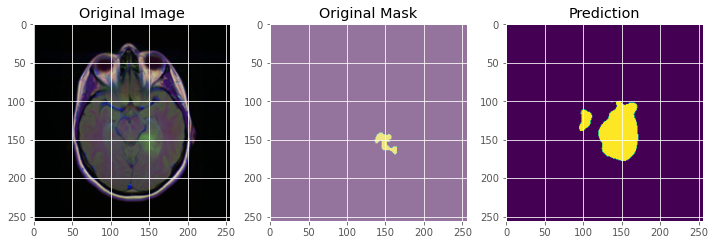

train_loss: 0.92695 valid_loss: 0.92691


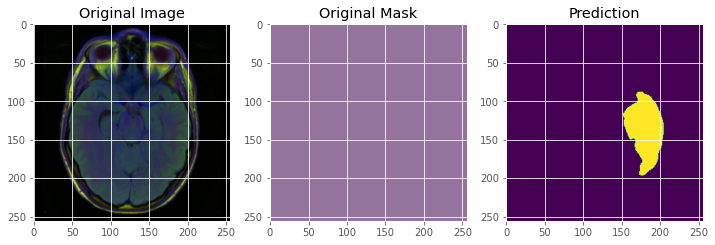

train_loss: 0.90846 valid_loss: 0.90700


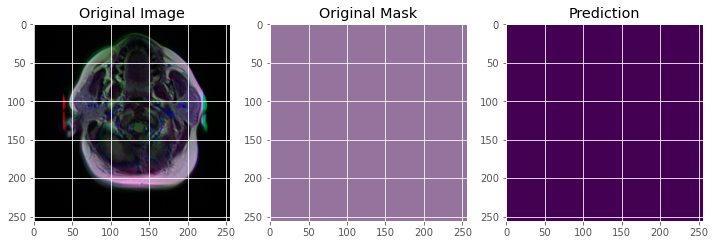

train_loss: 0.88226 valid_loss: 0.87968


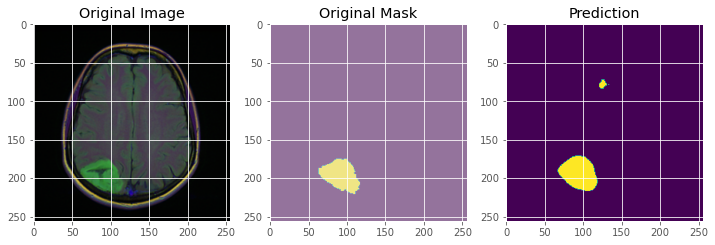

train_loss: 0.83269 valid_loss: 0.83558


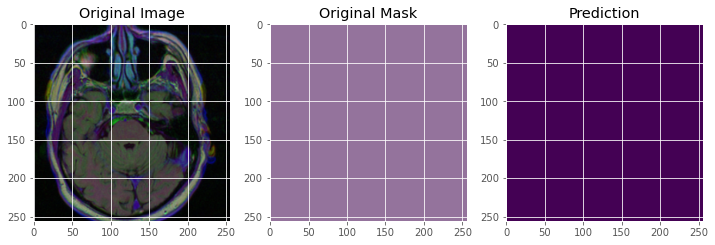

train_loss: 0.71357 valid_loss: 0.70349


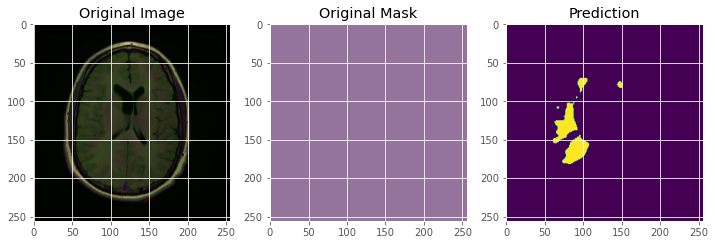

train_loss: 0.57591 valid_loss: 0.57519


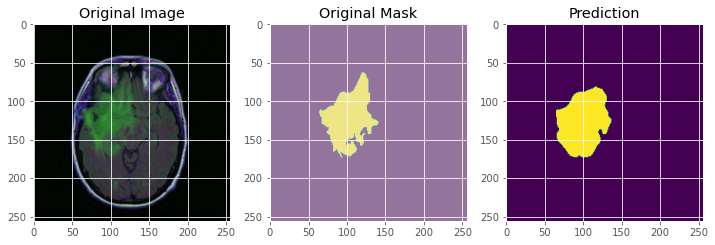

train_loss: 0.46306 valid_loss: 0.52561


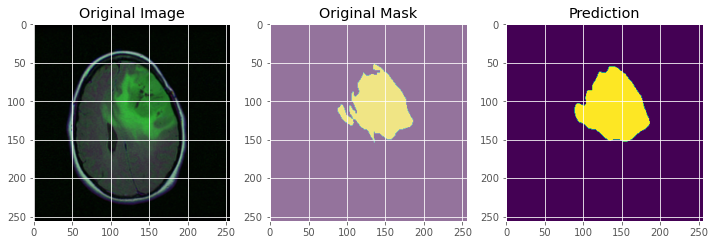

train_loss: 0.38139 valid_loss: 0.48798


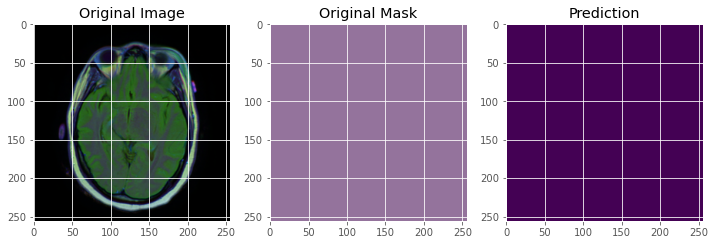

train_loss: 0.33071 valid_loss: 0.39644


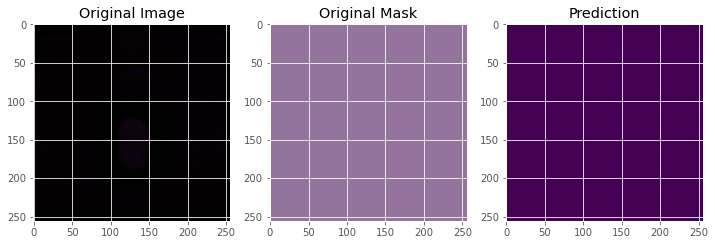

train_loss: 0.26986 valid_loss: 0.34966


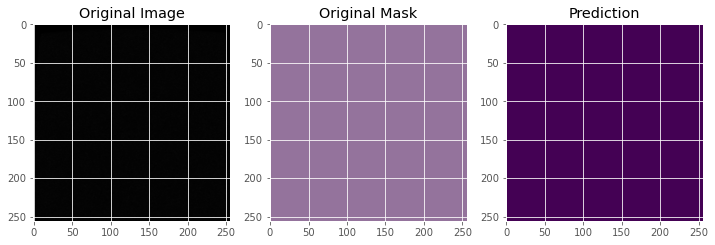

train_loss: 0.23984 valid_loss: 0.32145


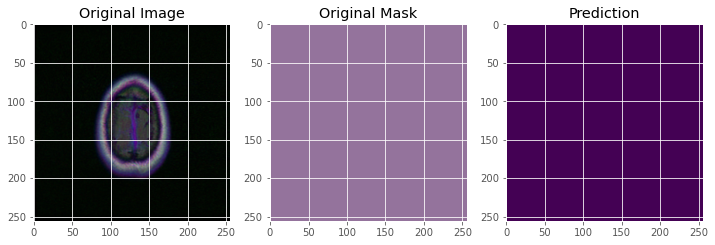

train_loss: 0.23170 valid_loss: 0.40567
Early Stopping Triggered With Patience 1


NameError: name 'avg_valid_losses' is not defined

In [21]:
#Train the model 
best_model, avg_train_losses, avg_val_losses = train(model, epochs)

In [2]:
#Load the model for testing 
test_model = UNet().to(device)
test_model.load_state_dict(torch.load(PATH))

NameError: name 'UNet' is not defined

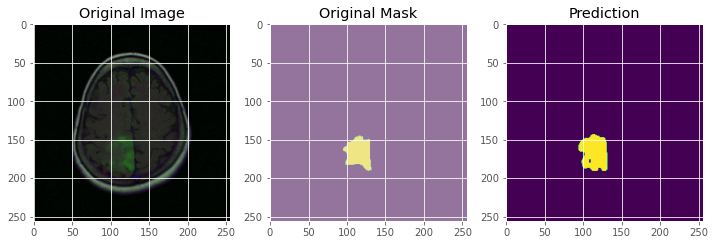

In [46]:
#Test the model with some samples from the test dataset 
model.eval()

(img, mask) = next(iter(test_dataloader))
img = img.to(device)
mask = mask.to(device)
mask = mask[0]
pred = model(img)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img.cpu().numpy()).transpose(1,2,0))
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow((mask.cpu().numpy()).transpose(1,2,0).squeeze(axis=2), alpha=0.5)
plt.title('Original Mask')
plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred.cpu()) > .5)
plt.title('Prediction')
plt.show()